## TREC-IS Dataset Procesing:


### Dataset cleaning.

### Feature Engineering.
>* **NER feature:** number of location, person, organization mentioned in tweets.
>* **Social feature:** number of friends, followers, retweet.
>* **Morphological features:** number of words, upper case words, emoji, hashtags and URLs.
>* **Sentiment features:** number of positive and negative words. 

### Dataset observation

### Data augmentation. 
>* Easy Data Augmentation Techniques (EDA) https://github.com/jasonwei20/eda_nlp 


<img src="image/word_map.png" width="700">

## 1. Load dataset and feature extraction

In [1]:
import pandas as pd
import json
import codecs
import gzip
import numpy as np
import re

import nltk
import emoji
import spacy
import en_core_web_sm
from collections import Counter

from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import ast
import os

In [2]:
url_pattern = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
username_pattern = r"@[^\s]+"
hashtag_pattern = r"\B#\w\w+"

In [3]:
file_list = os.listdir('./data')

# load whole dataset, including train and test.
data = []
for f in file_list:
    file_path = 'data/'+f
    if file_path.endswith('.gz'): 
        with gzip.GzipFile(file_path, 'r') as gz:
            for text in gz:
                data.append(json.loads(text))
    
# load labels, including train and test.
labels = []
with open('data/TRECIS_2018_2019-labels.json', 'r') as f:
    for i in json.load(f):
        labels.append(i)

In [4]:
# load 2019-A testset.
file_test_list = os.listdir('./data/test')
data_te = []
for f in file_test_list:
    file_path = 'data/test/'+f
    if file_path.endswith('.gz'): 
        with gzip.GzipFile(file_path, 'r') as gz:
            for text in gz:
                data_te.append(json.loads(text))

In [5]:
print("the size of 2019-A test set: ", len(data_te))
print("the size of whole dataset: ",len(data))
print("the size of labeled dataset: ", len(labels))

the size of 2019-A test set:  9503
the size of whole dataset:  50490
the size of labeled dataset:  38478


In [6]:
labels[0] # 'postID'.

{'eventID': 'joplinTornado2011',
 'eventName': '2011 Joplin Tornado',
 'eventDescription': "The 2011 Joplin tornado was a catastrophic EF5-rated multiple-vortex tornado that struck Joplin, Missouri, late in the afternoon of Sunday, May 22, 2011. The user is a response officer in the Missouri command and control center responsible for impact to the state. <a href='https://en.wikipedia.org/wiki/2011_Joplin_tornado' target='_blank'>Wikipedia Page<a>",
 'eventType': 'Unknown',
 'postID': '72676276212731904',
 'postCategories': ['Factoid', 'Hashtags', 'News'],
 'postPriority': 'Low'}

In [7]:
print("id: ", data[0]['allProperties']['docno'])
print("content: ", data[0]['allProperties']['content'])

id:  230634706436227073
content:  Philippine floods worsen as death toll hits 14 in wake of ‘Gener’ http://t.co/gnhkYRS6 #Philippines #national


In [8]:
nlp = en_core_web_sm.load()

doc = nlp(data[0]['allProperties']['content'])
dic_inf = Counter([X.label_ for X in doc.ents])

In [9]:
# show features.
print("1. location: ", dic_inf['LOC'])
print("2. Nationalities or religious or political: ", dic_inf['NORP'])
print("3. Person: ", dic_inf['PERSON'])
print("4. Organization: ", dic_inf['ORG'])
print("5. Hashtag: ", len(ast.literal_eval(data[0]['allProperties']['entities.hashtags'])))
print("6. Retweet: ", data[0]['allProperties']['retweet_count'])
print("7. Friends: ", data[0]['allProperties']['user.friends_count'])
print("8. Followers: ", data[0]['allProperties']['user.followers_count'])
print("9. Emoji: ", len(re.findall(emoji.get_emoji_regexp(), data[0]['allProperties']['content'])))
print("10. URLs: ", len(re.findall(url_pattern, data[0]['allProperties']['content'])))
token_list = RegexpTokenizer(pattern = r"\b[A-Za-z][A-Za-z]+\b").tokenize(data[0]['allProperties']['content'])
print("11. Words: ", len(token_list))
upper_case_list = RegexpTokenizer(pattern = r"\b[A-Z][A-Z]+\b").tokenize(data[0]['allProperties']['content'])
print("12. Upper case words: ",len(upper_case_list))

# nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
pos_num, neg_num = 0, 0


for word in token_list:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_num+=1
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_num+=1
    else:
        pass         

print("13. Positive: ", pos_num)           
print("14. Negative: ", neg_num)


1. location:  0
2. Nationalities or religious or political:  1
3. Person:  0
4. Organization:  0
5. Hashtag:  2
6. Retweet:  0
7. Friends:  889
8. Followers:  491
9. Emoji:  0
10. URLs:  1
11. Words:  15
12. Upper case words:  0
13. Positive:  0
14. Negative:  2


In [10]:
# use set for seperating dataset into train and test.
test_set = set()

for i in range(len(data_te)):
    test_set.add(data_te[i]['allProperties']['docno'])
    
print(len(test_set))

9308


In [11]:
# match labels and data.
labels_dict = dict()

for i, l in enumerate(labels):
    labels_dict[l['postID']] = i

In [12]:
# construct dataset dataframe.
raw_label_dataset = pd.DataFrame(columns=['content', 'categories', 'priority'])
raw_label_testset = pd.DataFrame(columns=['content', 'categories', 'priority'])
raw_unlabel_dataset = pd.DataFrame(columns=['content', 'categories', 'priority'])

features_list = ['loc', 'norp', 'person', 'org', 'friends', 'followers', 'retweet', 'hashtag', 'words', 'upper case words', 'emoji', 'urls', 'pos', 'neg', 'categories', 'priority']
label_feature_dataset = pd.DataFrame(columns=features_list)
label_feature_testset = pd.DataFrame(columns=features_list)
unlabel_feature_dataset = pd.DataFrame(columns=features_list)

for doc in tqdm(data):
    doc_id, doc_cont = doc['allProperties']['docno'], doc['allProperties']['content']
    
    # NER featuress.
    dic_inf = Counter([x.label_ for x in nlp(doc_cont).ents])
    loc, norp, person, org = dic_inf['LOC'], dic_inf['NORP'], dic_inf['PERSON'], dic_inf['ORG']
    
    # social features.
    friends = len(doc['allProperties']['user.friends_count']) if 'user.friends_count' in doc['allProperties'] else 0
    followers = len(doc['allProperties']['user.followers_count']) if 'user.followers_count' in doc['allProperties'] else 0
    retweets = len(doc['allProperties']['retweet_count']) if 'retweet_count' in doc['allProperties'] else 0
    
    # morphological features.
    token_list = RegexpTokenizer(pattern = r"\b[A-Za-z][A-Za-z]+\b").tokenize(doc_cont)
    upper_case_list = RegexpTokenizer(pattern = r"\b[A-Z][A-Z]+\b").tokenize(doc_cont)
    words = len(token_list)
    upper_words = len(upper_case_list)
    emo = len(re.findall(emoji.get_emoji_regexp(), doc_cont))
    
    if 'entities.hashtags' in doc['allProperties']:
        hashtag = len(doc['allProperties']['entities.hashtags']) if type(doc['allProperties']['entities.hashtags']) == list else len(ast.literal_eval(doc['allProperties']['entities.hashtags']))
    else:
        hashtag = 0
        
    urls = len(re.findall(url_pattern, doc_cont))
    
    # pos & neg features.
    # nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    pos_num, neg_num = 0, 0


    for word in token_list:
        if (sid.polarity_scores(word)['compound']) >= 0.5:
            pos_num+=1
        elif (sid.polarity_scores(word)['compound']) <= -0.5:
            neg_num+=1
        else:
            pass  
        
    res = [loc, norp, person, org, friends, followers,retweets, hashtag, words, upper_words, emo, urls, pos_num, neg_num]
    
    if doc_id not in labels_dict: 
        raw_unlabel_dataset = raw_unlabel_dataset.append({'content': doc_cont, 'categories': None, 'priority': None}, ignore_index=True)
        unlabel_feature_dataset = unlabel_feature_dataset.append(dict(zip(features_list, res+[None, None])), ignore_index=True)
    else:
        # load train and test respectively.
        index = labels_dict[doc_id]
        if doc_id in test_set:
            raw_label_testset = raw_label_testset.append({'content': doc_cont, 'categories': labels[index]['postCategories'], 'priority': labels[index]['postPriority']}, ignore_index=True)
            label_feature_testset = label_feature_testset.append(dict(zip(features_list, res+[labels[index]['postCategories'], labels[index]['postPriority']])), ignore_index=True)
        else:
            raw_label_dataset = raw_label_dataset.append({'content': doc_cont, 'categories': labels[index]['postCategories'], 'priority': labels[index]['postPriority']}, ignore_index=True)
            label_feature_dataset = label_feature_dataset.append(dict(zip(features_list, res+[labels[index]['postCategories'], labels[index]['postPriority']])), ignore_index=True)

In [13]:
print("size of label testset: ", len(raw_label_testset))
print("size of label dataset: ", len(raw_label_dataset))
print("size of unlabel dataset: ", len(raw_unlabel_dataset))

size of label testset:  8218
size of label dataset:  29155
size of unlabel dataset:  13117


In [14]:
raw_label_dataset[:5]

,content,categories,priority
0,Philippine floods worsen as death toll hits 14...,"[ThirdPartyObservation, Factoid, News]",Low
1,Philippine flood fatalities hit 23 http://t.co...,"[ThirdPartyObservation, Factoid, News]",Low
2,4 Luzon dams release water; flood warning up: ...,"[ThirdPartyObservation, Factoid, News]",Low
3,RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...,"[ThirdPartyObservation, Factoid, News]",Low
4,RT @ANCALERTS: PAGASA 4am advisory: Green warn...,"[ThirdPartyObservation, News]",Low


In [15]:
label_feature_dataset[:5]

,loc,norp,person,org,friends,followers,retweet,hashtag,words,upper case words,emoji,urls,pos,neg,categories,priority
0,0,1,0,0,3,3,1,2,15,0,0,1,0,2,"[ThirdPartyObservation, Factoid, News]",Low
1,0,1,0,0,1,4,1,0,6,0,0,1,0,1,"[ThirdPartyObservation, Factoid, News]",Low
2,2,0,0,1,1,2,1,0,20,1,0,1,0,0,"[ThirdPartyObservation, Factoid, News]",Low
3,0,0,0,1,3,3,3,0,17,3,0,0,0,0,"[ThirdPartyObservation, Factoid, News]",Low
4,0,0,1,0,3,3,3,0,22,3,0,0,0,2,"[ThirdPartyObservation, News]",Low


In [16]:
raw_label_dataset.to_csv("pre-processed data/raw_label_dataset.csv", index=False)

## 2. data cleaning

In [17]:
# nltk.download('wordnet')

stopwords = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its', 'rt', 'about']

In [18]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

In [19]:
def text_processor(df):
    drop_index = []
    df_new = pd.DataFrame(columns=['content', 'categories', 'priority'])
    for i in tqdm(range(len(df))):
        
        content, categories, priority = df.loc[i, 'content'], df.loc[i, 'categories'], df.loc[i, 'priority']
        
        # remove url.
        content_url = re.sub(url_pattern, "", content)
        
        # remove @username. 
        content_username = re.sub(username_pattern, "", content_url)
    
        # remove #hashtag.
        content_hashtag = re.sub(hashtag_pattern, "", content_username)
        
        # lower case.
        content_lower = content_hashtag.lower()
        
        # tokenisation.
        token_list = RegexpTokenizer(pattern = r"\b[A-Za-z][A-Za-z]+\b").tokenize(content_lower)
        
        # split words connected by hyphen.
        text = str()
        for j in token_list:
            text += j.replace("-", " ")
            text += " "
        token_list = word_tokenize(text)
        
        # POS.
        token_words = pos_tag(token_list)
        
        # WordNetLemmatizer
        words_lematizer = []
        wordnet_lematizer = WordNetLemmatizer()
        
        for word, tag in token_words:
            if tag.startswith('NN'):
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='n')  
            elif tag.startswith('VB'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='v')  
            elif tag.startswith('JJ'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='a')  
            elif tag.startswith('R'): 
                word_lematizer =  wordnet_lematizer.lemmatize(word, pos='r')
            else: 
                word_lematizer =  wordnet_lematizer.lemmatize(word)
            words_lematizer.append(word_lematizer)
            
        # remove stop words.
        cleaned_words = [word for word in words_lematizer if word.lower() not in stopwords]
        
        # remove punctuation.
        characters = [',','’', '\'','.','DBSCAN', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','-','...','^','{','}','"']
        words_lists = [word for word in cleaned_words if word not in characters]
        text = str()
        for w in words_lists:
            text+=w
            text+=" "
            
        # remove emoji
        final_content = remove_emoji(text)
        
        if len(final_content.strip()) != 0:
            df_new = df_new.append({'content': final_content, 'categories': categories, 'priority': priority}, ignore_index=True)
        else:
            drop_index.append(i)
            
    return df_new, drop_index


In [20]:
new_label_dataset, drop_index_dataset = text_processor(raw_label_dataset)
new_label_testset, drop_index_testset = text_processor(raw_label_testset)
new_unlabel_dataset, drop_index_unlabel = text_processor(raw_unlabel_dataset)

In [21]:
print("* dataset before cleaning: ")
print(raw_label_dataset.loc[2, 'content'])
print(" ")
print("* dataset after cleaning: ")
print(new_label_dataset.loc[2, 'content'])

* dataset before cleaning: 
4 Luzon dams release water; flood warning up: MANILA, Philippines - Four dams in Luzon opened their gates Sunday... http://t.co/kmWDCBFw
 
* dataset after cleaning: 
luzon dam release water flood warn up manila philippine four dam luzon open gate sunday 


In [22]:
label_feature_dataset.drop(index=drop_index_dataset, inplace=True)
label_feature_testset.drop(index=drop_index_testset, inplace=True)
unlabel_feature_dataset.drop(index=drop_index_unlabel, inplace=True)

In [23]:
label_feature_dataset.to_csv("pre-processed data/label_feature_dataset.csv", index=False)
label_feature_testset.to_csv("pre-processed data/label_feature_testset.csv", index=False)
unlabel_feature_dataset.to_csv("pre-processed data/unlabel_feature_dataset.csv", index=False)

## 3. dataset distribution ( balance or not )

In [24]:
# ccounting the number of each category and priority.

cat_dict, prior_dict = dict(), dict()

for i in range(len(new_label_dataset)):
    cat, prior = new_label_dataset.loc[i, 'categories'], new_label_dataset.loc[i, 'priority']
    for c in cat:
        if c not in cat_dict:
            cat_dict[c] = 1
        else:
            cat_dict[c] += 1
    if prior not in prior_dict:
        prior_dict[prior] = 1
    else:
        prior_dict[prior] += 1

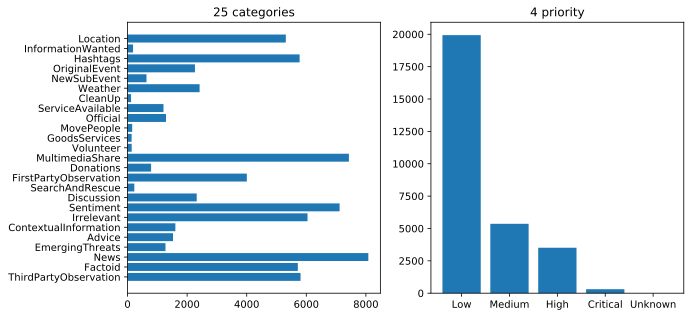

In [36]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
cat, cat_num = list(cat_dict), list(cat_dict.values())
prior, prior_num = list(prior_dict), list(prior_dict.values())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.barh(cat,cat_num)
# plt.xlabel("num")
# plt.ylabel("cat")
plt.title(str(25)+" categories")
plt.subplot(1, 2, 2)
plt.bar(prior,prior_num)
# plt.xlabel("prior")
# plt.ylabel("num")
plt.title(str(4)+" priority")
plt.show()

In [26]:
"""25 information type for multi-label tweet classification, four priorities for multi-class tweets classification."""

'25 information type for multi-label tweet classification, four priorities for multi-class tweets classification.'

In [27]:
# convert "categories" and "priority" column to vector
# cat_id, prior_id = [i for i in range(len(cat))], [i for i in range(len(prior))]
# id_to_cat, id_to_prior = dict(zip(cat, cat_id)), dict(zip(prior, prior_id))

# for i in tqdm(range(len(new_label_dataset))):
#     temp_cat, temp_prior = new_label_dataset.loc[i, 'categories'], new_label_dataset.loc[i, 'priority']
#     vec_cat, vec_prior = np.zeros(len(cat)), np.zeros(len(prior))
#     for index in temp_cat: 
#         vec_cat[id_to_cat[index]] = 1
        
#     vec_prior[id_to_prior[temp_prior]] = 1
#     new_label_dataset.loc[i, 'categories'] = vec_cat
#     new_label_dataset.loc[i, 'priority'] = vec_prior
#  new_label_dataset[:5]      

## 4. word cloud

In [28]:
from collections import Counter

In [29]:
def extract_ngrams(x_raw, ngram_range=1, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # fill in your code...
    pattern = re.compile(token_pattern)
    # 1. tokenise all texts into a list of unigrams.
    x_raw = pattern.findall(x_raw.lower())
    # 2. remove stop words.
    x_new = [i for i in x_raw if i not in stop_words]
    # 3. vocab.
    if len(vocab)!= 0:
        x = [i for i in x_new if i in vocab]
    else:
        x = x_new
     
    return x

In [30]:
def get_vocab(X_raw, ngram_range=1, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):

    df, unigram_counts = dict(), dict()
    
    # calculate df and tf.
    for l in X_raw:
        doc_list = extract_ngrams(l, ngram_range, token_pattern, stop_words, set()) 
        # key and counts have the same keys.
        key = list(set(doc_list))
        counts = Counter(doc_list) 
        for k in key:
            # df.
            df[k] = (df[k]+1) if k in df else 1
            # tf.
            unigram_counts[k] = (unigram_counts[k]+counts[k]) if k in unigram_counts else counts[k]   
            
    
    # choose unigrams that are bigger than min_df.
    df_key, df_value = np.array(list(df.keys())), np.array(list(df.values()))
    vocab = set(df_key[df_value > min_df])
    
    # update df & tf using vocab.
    for v in df_key:
        if v not in vocab:
            unigram_counts.pop(v)
            df.pop(v)
    
    # sort unigram_counts.
    unigram_counts = dict(sorted(unigram_counts.items(), key=lambda x:x[1], reverse=True))
    
    # choose top n.
    if (keep_topN != 0) and (keep_topN < len(vocab)):
        unigram_counts = dict(zip(list(unigram_counts.keys())[:keep_topN], list(unigram_counts.values())[:keep_topN]))
        
    # update vocab.
    vocab = set(unigram_counts.keys())
    
    # update df.
    df_key = list(df.keys())
    for v in df_key:
        if v not in vocab:
            df.pop(v)
    
    return vocab, df, unigram_counts

In [31]:
dataset = list(new_label_dataset['content'])
vocab, df, unigram_counts = get_vocab(dataset, stop_words=stopwords, keep_topN=5000)

print("size of vocab: ", len(vocab))
print("Top 10 most common words: ", list(unigram_counts.items())[:10])

size of vocab:  5000
Top 10 most common words:  [('earthquake', 2846), ('school', 2577), ('shoot', 2453), ('nepal', 2414), ('philippine', 2358), ('people', 2307), ('flood', 2133), ('typhoon', 1981), ('after', 1970), ('fire', 1675)]


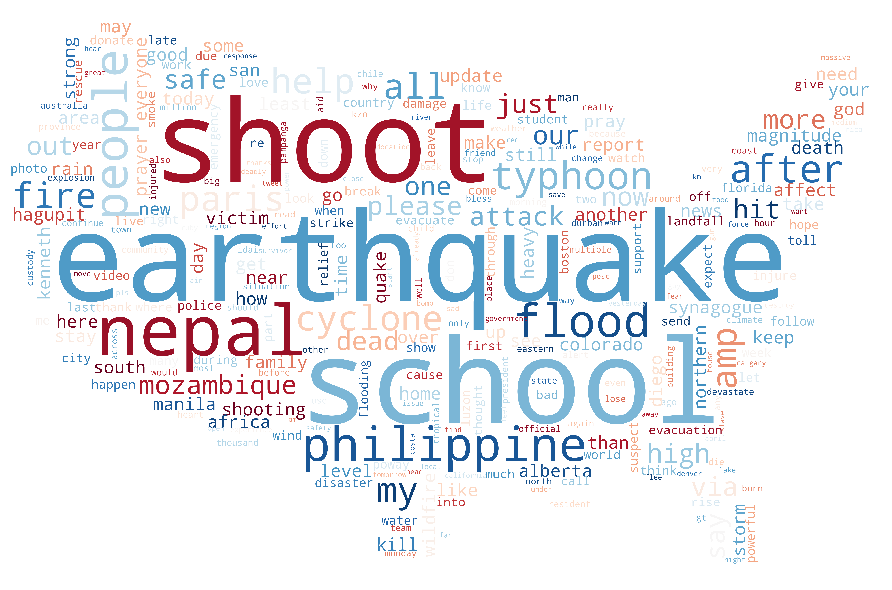

In [32]:
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import imageio

mk = imageio.imread("image/usa.png")

plt.figure(figsize=(18, 8))
wc = WordCloud(background_color="white",max_font_size=70, 
               max_words=300,mask=mk,scale=15, collocations=False, colormap="RdBu_r").generate_from_frequencies(unigram_counts)

plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wc)
plt.savefig('image/word_map.png')

In [33]:
# save processed dataset to csv.
new_label_dataset.to_csv('pre-processed data/new_label_dataset.csv')
new_unlabel_dataset.to_csv('pre-processed data/new_unlabel_dataset.csv')
new_label_testset.to_csv('pre-processed data/new_label_testset.csv')

## 5. Data Augmentation

### 5.1 "Priority"

In [34]:
# data augmentation - synonym replacement [low = 27477, critical = 423, medium prior = 6195, high = 4382]

# critical, medium prior and high shoud be increased to 9000.
from nltk.corpus import wordnet

dataset_other = new_label_dataset[new_label_dataset['priority'] != 'Low']

dataset_critical = dataset_other[dataset_other['priority'] == 'Critical'][['priority', 'content']]
dataset_medium = dataset_other[dataset_other['priority'] == 'Medium'][['priority', 'content']]
dataset_high = dataset_other[dataset_other['priority'] == 'High'][['priority', 'content']]

dataset_critical.to_csv("data-augmentation/dataset_critical.tsv", sep='\t', header=False, index=False) # 21
dataset_medium.to_csv("data-augmentation/dataset_medium.tsv", sep='\t', header=False, index=False) # 1
dataset_high.to_csv("data-augmentation/dataset_high.tsv", sep='\t', header=False, index=False) # 2

In [35]:
# Easy Data Augmentation (EDA) 
# python code/augment.py --input=sst2_train.txt --output=sst2_augmented.txt --num_aug=16 --alpha=0.05

In [36]:
# load dataset after data augmentation.

dataset_aug_critical = pd.read_csv("pre-processed data/dataset_aug_critical.tsv", sep='\t', header=None)
dataset_aug_medium = pd.read_csv("pre-processed data/dataset_aug_medium.tsv", sep='\t', header=None)
dataset_aug_high = pd.read_csv("pre-processed data/dataset_aug_high.tsv", sep='\t', header=None)

dataset_aug_temp = pd.concat([dataset_aug_critical, dataset_aug_medium])
dataset_aug_other = pd.concat([dataset_aug_temp, dataset_aug_high])

print("dataset with label 'critical':", len(dataset_aug_critical))
print("dataset with label 'medium':", len(dataset_aug_medium))
print("dataset with label 'high':", len(dataset_aug_high))
print("dataset with label 'low': ", len(new_label_dataset[new_label_dataset['priority'] != 'Low']))

dataset with label 'critical': 1535
dataset with label 'medium': 10722
dataset with label 'high': 10536
dataset with label 'low':  9181


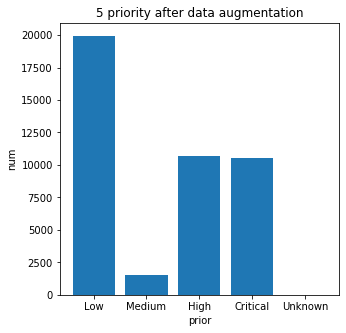

In [37]:
prior_1, prior_num_1 = list(prior_dict), [len(new_label_dataset[new_label_dataset['priority'] == 'Low']), len(dataset_aug_critical), len(dataset_aug_medium), len(dataset_aug_high), 0]

plt.figure(figsize=(5, 5))

plt.bar(prior_1,prior_num_1)
plt.xlabel("prior")
plt.ylabel("num")
plt.title(str(len(prior_1))+" priority after data augmentation")
plt.show()

In [38]:
dataset_aug_other.rename(columns = {0: "priority", 1: "content"}, inplace=True)

# concat them together.
dataset_aug_priority = pd.concat([new_label_dataset[new_label_dataset['priority'] == 'Low'][['priority', 'content']], dataset_aug_other])

print("new dataset: ", len(dataset_aug_priority))

new dataset:  42726


In [39]:
dataset_aug_priority.to_csv("pre-processed data/dataset_aug_priority.csv", index=False)

### 5.2 "categories"

increasing the amount of data that only includes uncommon labels. Those uncommon labels (<1000) include 'volunteer', 'goodServices' and others. 

In [40]:
new_label_dataset[:3]

,content,categories,priority
0,philippine flood worsen death toll hit wake ge...,"[ThirdPartyObservation, Factoid, News]",Low
1,philippine flood fatality hit,"[ThirdPartyObservation, Factoid, News]",Low
2,luzon dam release water flood warn up manila p...,"[ThirdPartyObservation, Factoid, News]",Low


In [41]:
# sort label according to their occupation.

# firstly, increase labels that are less than 1000.
sort_cat_top_8 = dict(sorted(cat_dict.items(), key=lambda x: x[1], reverse=False)[:8])

cat_index = dict(zip(sort_cat_top_8, [i for i in range(25)]))

In [42]:
sort_cat_top_8

{'CleanUp': 118,
 'GoodsServices': 137,
 'Volunteer': 139,
 'MovePeople': 156,
 'InformationWanted': 185,
 'SearchAndRescue': 228,
 'NewSubEvent': 637,
 'Donations': 791}

In [43]:
new_dataset_top_8 = pd.DataFrame(columns=['categories', 'content'])
for i in range(len(new_label_dataset)):
    state = True
    for c in new_label_dataset.loc[i, 'categories']:
        if c not in sort_cat_top_8:
            state = False
    if state:
        new_dataset_top_8 = new_dataset_top_8.append({'categories':new_label_dataset.loc[i, 'categories'], 
                                                      'content': new_label_dataset.loc[i, 'content']}, ignore_index=True)     

print("num: ", len(new_dataset_top_8))

num:  513


In [44]:
new_dataset_top_8.to_csv("data-augmentation/dataset_top_8.tsv", sep='\t', header=False, index=False)

In [45]:
new_dataset_top_8[:10]

,categories,content
0,[SearchAndRescue],rescue need romualdez st cor kalentong house b...
1,"[GoodsServices, SearchAndRescue]",ust hospital generator already die
2,"[GoodsServices, Donations]",pls remember ateneo h kitchen cook food cook f...
3,"[Volunteer, Donations]",ua amp bea catalyst use donation please check ...
4,"[GoodsServices, Donations]",more medicine plastic box need ua amp please d...
5,[Volunteer],fyi prepare second deployment volunteer volunt...
6,[Donations],feed program bgy silangan qc ongoing hot arroz...
7,[InformationWanted],live webcam
8,[Donations],early now make ur donation already prepare dis...
9,[Volunteer],aid call volunteer


In [46]:
dataset_aug_top_8 = pd.read_csv("pre-processed data/dataset_aug_top_8.tsv", sep='\t', header=None, names=['categories', 'content'])

print("num: ", len(dataset_aug_top_8))

num:  16492


In [47]:
dataset_aug_cat = pd.concat([new_label_dataset[['content', 'categories']], dataset_aug_top_8[['content', 'categories']]], sort=False)
dataset_aug_cat = dataset_aug_cat.reset_index(drop=True)
print("new size: ", len(dataset_aug_cat))

dataset_aug_cat[:10]

new size:  45606


,content,categories
0,philippine flood worsen death toll hit wake ge...,"[ThirdPartyObservation, Factoid, News]"
1,philippine flood fatality hit,"[ThirdPartyObservation, Factoid, News]"
2,luzon dam release water flood warn up manila p...,"[ThirdPartyObservation, Factoid, News]"
3,pagasa advisory yellow warning metro manila oc...,"[ThirdPartyObservation, Factoid, News]"
4,pagasa advisory green warning metro manila mod...,"[ThirdPartyObservation, News]"
5,anc pagasa advisory green warning metro manila...,"[ThirdPartyObservation, News]"
6,pagasa advisory green warning metro manila hea...,"[ThirdPartyObservation, News]"
7,pagasa advisory red warning metro manila heavy...,"[ThirdPartyObservation, EmergingThreats, News]"
8,pagasa advisory red warning metro manila heavy...,"[ThirdPartyObservation, EmergingThreats, News]"
9,flood end up bang up my manila badly consider ...,"[ThirdPartyObservation, Advice]"


In [48]:
import ast
new_cat_dict = dict(zip(cat, [0 for _ in range(25)]))
for i in range(len(dataset_aug_cat)):
    inf = dataset_aug_cat.loc[i, 'categories']
    if type(inf) == str:
        inf = ast.literal_eval(inf)
    for i in inf:
        new_cat_dict[i] += 1

In [49]:
new_cat_dict

{'ThirdPartyObservation': 5807,
 'Factoid': 5716,
 'News': 8082,
 'EmergingThreats': 1274,
 'Advice': 1526,
 'ContextualInformation': 1606,
 'Irrelevant': 6041,
 'Sentiment': 7118,
 'Discussion': 2322,
 'SearchAndRescue': 2088,
 'FirstPartyObservation': 4004,
 'Donations': 6774,
 'MultimediaShare': 7430,
 'Volunteer': 883,
 'GoodsServices': 1315,
 'MovePeople': 1117,
 'Official': 1291,
 'ServiceAvailable': 1207,
 'CleanUp': 242,
 'Weather': 2419,
 'NewSubEvent': 2621,
 'OriginalEvent': 2263,
 'Hashtags': 5776,
 'InformationWanted': 2789,
 'Location': 5313}

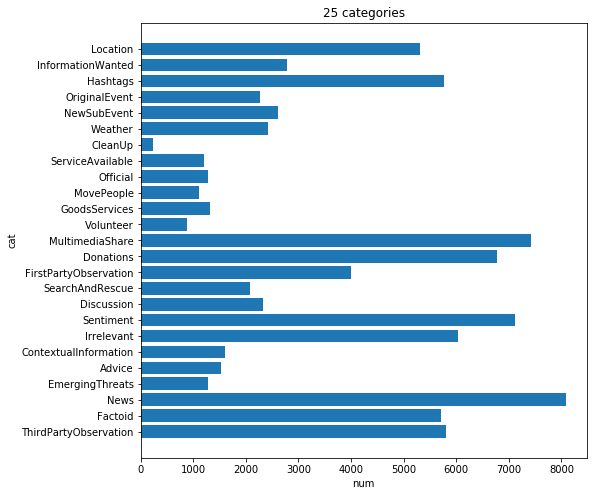

In [50]:
import matplotlib.pyplot as plt
cat_1, cat_num_1 = list(new_cat_dict), list(new_cat_dict.values())

plt.figure(figsize=(8, 8))
plt.barh(cat_1,cat_num_1)
plt.xlabel("num")
plt.ylabel("cat")
plt.title(str(len(cat))+" categories")
plt.show()

In [51]:
dataset_aug_cat.to_csv("pre-processed data/dataset_aug_cat.csv", index=False)

In [52]:
# to be continue ...